In [4]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

# [1] 빈칸을 작성하시오.
# Connect Directory
%cd "/content/drive/MyDrive/OUTTA2024/2024-outta-deeplearning-advanced"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/OUTTA2024/2024-outta-deeplearning-advanced


In [5]:
!pip install diffusers
!pip install -q -U google-generativeai
!pip install accelerate

In [6]:
import os
import sys
import random
from io import BytesIO

import cv2
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import requests

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.models.vgg as vgg

from diffusers import StableDiffusionInpaintPipeline
from huggingface_hub import hf_hub_download

from read_dataset import read_dataset
from model import segmentation_model
from train import train
from segmentation import segementation
from diffusion import *
from llm import *
from preprop import *

# Jupyter Notebook 내에서 matplotlib 출력 설정
%matplotlib inline

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 32   # 절대 바꾸지 마세요.

model = segmentation_model().to(device)

# 하이퍼파라이터
epoch = 5
learning_rate = 0.00001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# **1. Train**

In [8]:
file_path = 'dataset/G2_train.h5'
data_len = 10000
img_list, gt_list = read_dataset(file_path, data_len)

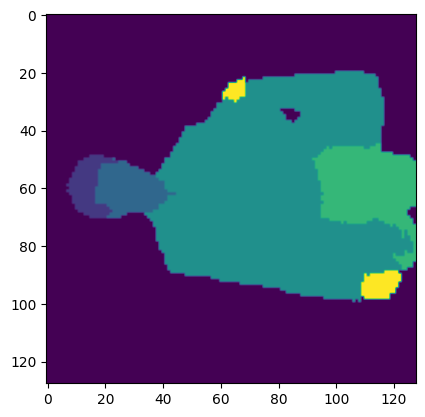

tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8)

In [9]:
a=gt_list[9999]
plt.imshow(a.squeeze(0))
plt.show()
a = torch.tensor(a)
a.unsqueeze(0)

In [10]:
# train(img_list, gt_list, model, epoch, learning_rate, optimizer, criterion, data_len)

In [11]:
# torch.save(model.state_dict(), "/content/drive/MyDrive/OUTTA2024/2024-outta-deeplearning-advanced/model_params/model_state_dict{epoch-1}.pth")

# **2. Inference**

## **(1) Set the Model into Eval Mode**

In [12]:
model = segmentation_model()

# 가중치를 CPU로 로드
model.load_state_dict(torch.load(f'/content/drive/MyDrive/OUTTA2024/2024-outta-deeplearning-advanced/model_params/model_state_dict{epoch-1}.pth', map_location=torch.device('cpu')))

# 모델을 평가 모드로 설정
model.eval()

segmentation_model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padd

## **(2) Load Image**

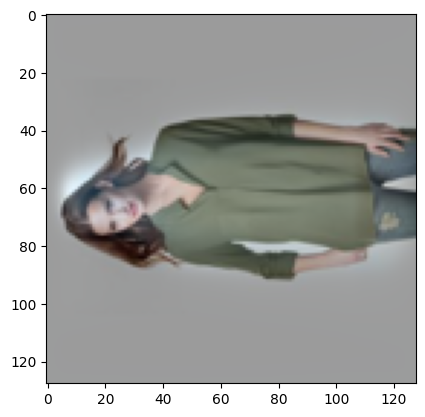

(128, 128, 3)


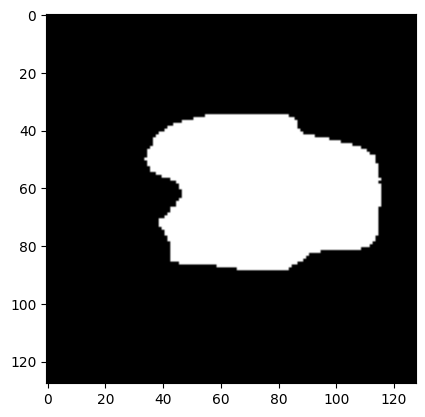

In [13]:
image = np.load('./test_image3.npy')
plt.imshow(image)
plt.show()
print(image.shape)

# 결과 시각화
vis_output_model = segementation(image, model)
plt.imshow(vis_output_model)
plt.show()

## **(3) Inference**

### **1) LLM**

In [14]:
# [2] 빈칸을 작성하시오.
# 적절한 프롬프트 튜닝을 통해서, 좋은 성능을 내보세요.
# [Example]
# prompt = "A Red short skirt, high quality, detailed, cute, with a lot of details, ."
# negative_prompt = "ugly"
prompt = "should wear a red short skirt. High quality image."
negative_prompt = "ugly"

text = LLM(prompt)
text.text

"```python\nclothing = {\n    'top': [],\n    'bottom': [['red', 'short skirt']]\n}\n```"

### **2) Segmentation & Inpainting**
- SAM for Segmentation

- Stable Diffusion for inpainting

In [15]:
# [3] 빈칸을 작성하시오.
# 사전학습된 StableDiffusionInpaintPipeline 불러오고, GPU로 로드
sd_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

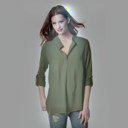

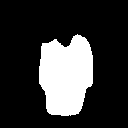

In [16]:
# [4] 빈칸을 작성하시오.
# 이미지와 모델을 받아 Diffusion 모델에 적합한 형태로 전처리하는 함수 호출
image_source_pil, image_mask_pil = preprop_for_diffusion(image, vis_output_model)

  0%|          | 0/50 [00:00<?, ?it/s]

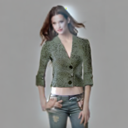

In [17]:
# [5] 빈칸을 작성하시오.
# 이미지 생성 함수 호출: 주어진 이미지와 마스크를 기반으로 새로운 이미지를 생성
generated_image = generate_image(image_source_pil, image_mask_pil, prompt, negative_prompt, sd_pipe, seed, device)

generated_image


# [6] 빈칸을 작성하시오.
# 생성된 이미지의 크기 조정
# resized_image =

In [18]:
# resized_image